In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
from scipy.special import comb
from scipy.stats import zscore
import matplotlib
sns.set_theme(style="ticks")

In [2]:
def process(df):
    # Select variables
    vars = ['Graph Name',
            'num_vertices',
            'num_edges',
            'assortativity_coeff',
            'clustering_local_avg']
    
    # Make deep copy
    df_processed = df[vars].copy()
    
    # Drop invalid values
    df_processed.dropna(inplace=True) 
    
    # Add quantities
    df_processed['density'] = df_processed['num_edges'] / comb(df_processed['num_vertices'],2)
    df_processed['log_density'] = df_processed['density'].apply(np.log10)
    df_processed['log_size'] = df_processed['num_vertices'].apply(np.log10)
    
    # Drop values out of range
    idx = (df_processed['density'] <= 1) & \
          (df_processed['assortativity_coeff'].between(-1,1)) & \
          (df_processed['clustering_local_avg'].between(0,1))
    df_processed = df_processed[idx]
    
    # Scale columns
    df_processed['log_density_norm'] = zscore(df_processed['log_density'])
    df_processed['assortativity_norm'] = zscore(df_processed['assortativity_coeff'])
    df_processed['clustering_norm'] = zscore(df_processed['clustering_local_avg'])
    
    # Reset index
    df_processed.reset_index(inplace=True,drop=True)
    
    return df_processed


# Process

In [3]:
# Read CSV
df = pd.read_csv('db01.csv')

# Process DF
df_processed = process(df)
df_processed

,Graph Name,num_vertices,num_edges,assortativity_coeff,clustering_local_avg,density,log_density,log_size,log_density_norm,assortativity_norm,clustering_norm
0,f socfb-A-anon,3000000.0,24000000.0,-0.06,0.10,0.000005,-5.273001,6.477121,-1.888394,-0.276047,-0.836462
1,f socfb-American75,6000.0,218000.0,0.07,0.24,0.012113,-1.916744,3.778151,0.577489,0.411203,-0.025414
2,f socfb-Amherst41,2000.0,91000.0,0.06,0.31,0.045523,-1.341771,3.301030,0.999928,0.358337,0.380111
3,f socfb-Auburn71,18000.0,974000.0,0.00,0.22,0.006013,-2.220932,4.255273,0.353998,0.041145,-0.141278
4,f socfb-B-anon,3000000.0,21000000.0,-0.11,0.09,0.000005,-5.330993,6.477121,-1.931002,-0.540374,-0.894394
...,...,...,...,...,...,...,...,...,...,...,...
207,ia-southernwomen,18.0,75.0,-0.21,0.74,0.490196,-0.309630,1.255273,1.758255,-1.069028,2.871187
208,ia-wiki-Talk-dir,2000000.0,5000000.0,-0.29,0.07,0.000003,-5.602060,6.301030,-2.130158,-1.491951,-1.010258
209,ia-wiki-Talk,92000.0,361000.0,-0.03,0.06,0.000085,-4.069034,4.963788,-1.003825,-0.117451,-1.068190
210,ia-wiki-trust-dir,139000.0,740000.0,-0.05,0.29,0.000077,-4.115765,5.143015,-1.038159,-0.223182,0.264247


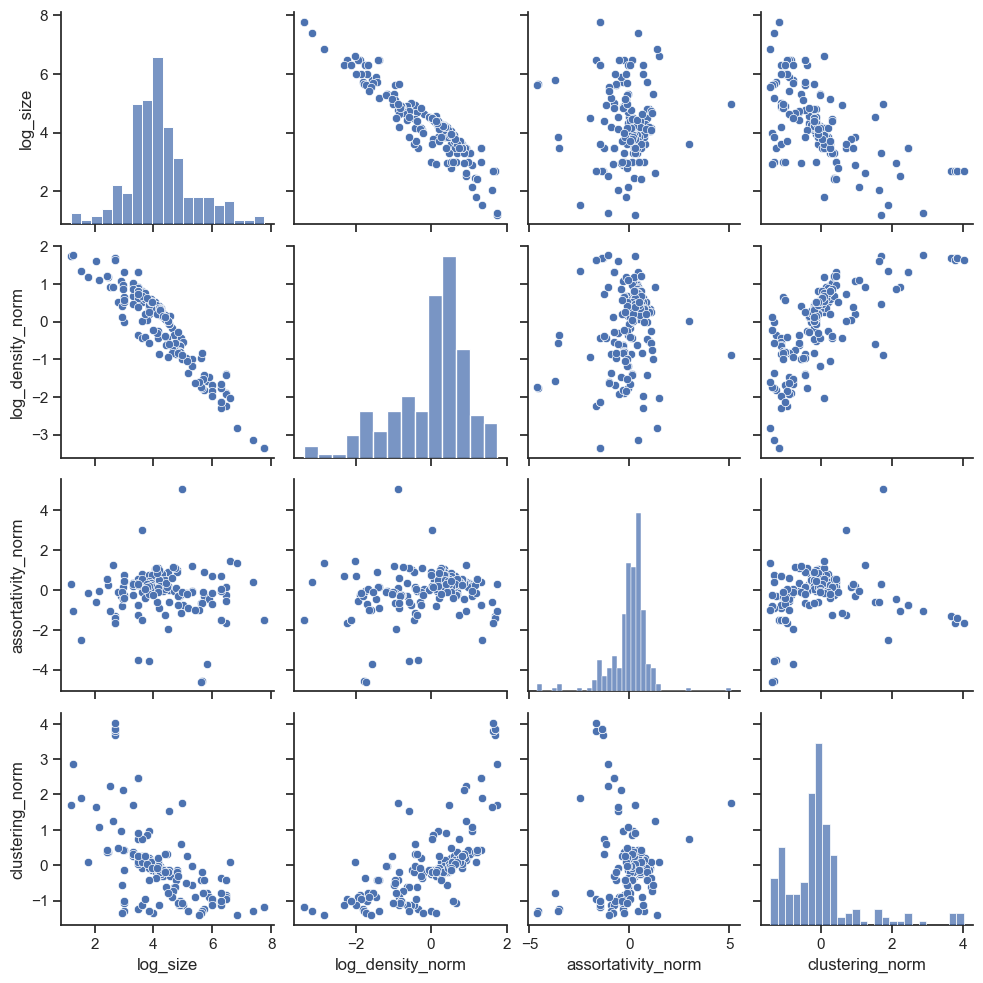

In [4]:
# Visualize
vars = ['log_size',
        'log_density_norm',
        'assortativity_norm',
        'clustering_norm']
sns.pairplot(df_processed,vars=vars)

# Cluster

In [22]:
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def cluster_dataframe(df, vars, n_clusters=3):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[vars])

    # Perform k-means clustering
    kmeans = Birch(n_clusters=n_clusters)
    df['Cluster'] = kmeans.fit_predict(scaled_data)
    df['Cluster'] = df['Cluster'].astype('category')

    return df, kmeans

def plot_clusters(df,vars):
    # Reduce to two dimensions using PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[vars])

    # Add PCA results to the dataframe
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=100)

    # Add a legend
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title('2D Visualization of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()
    
    return pca

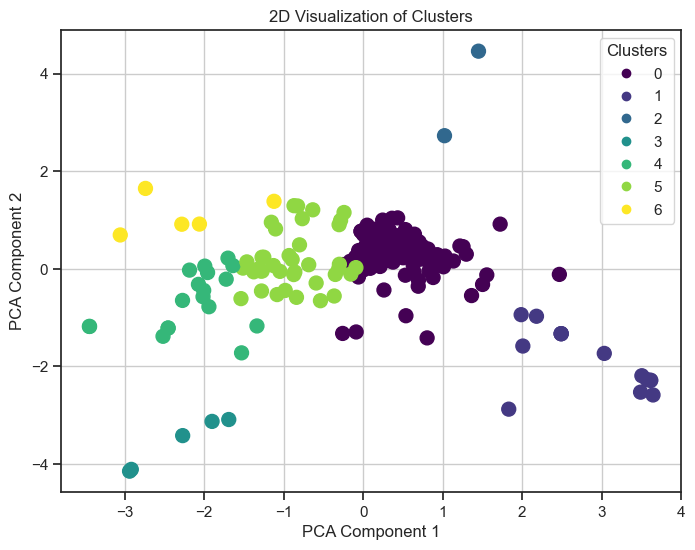

In [23]:
vars = ['log_density_norm',
        'assortativity_norm',
        'clustering_norm']

df_processed,_ = cluster_dataframe(df_processed,vars,n_clusters=7)
U = plot_clusters(df_processed,vars)

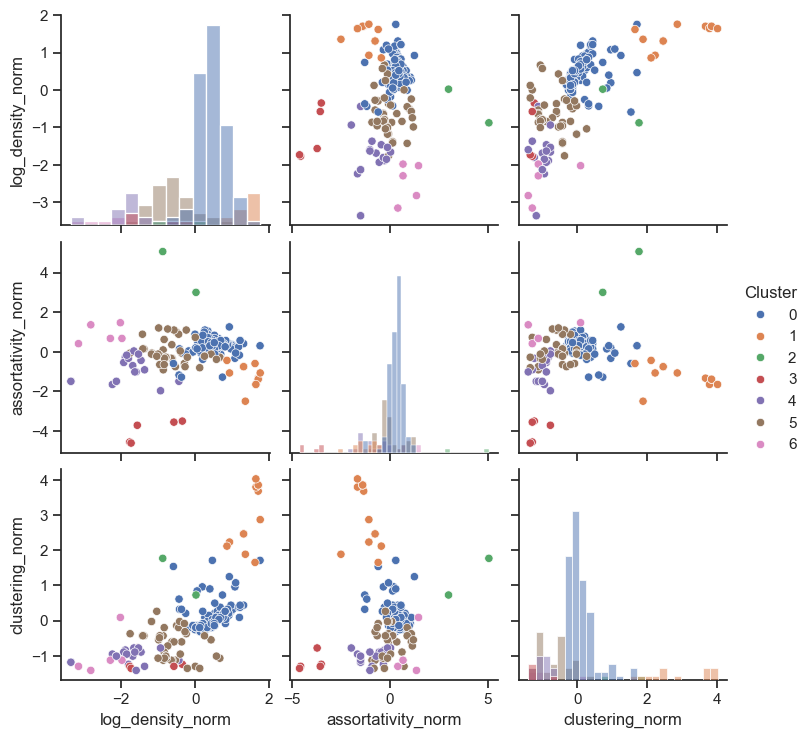

In [7]:
sns.pairplot(df_processed,vars=(vars),hue='Cluster',diag_kind='hist')

<Axes: xlabel='log_size', ylabel='Cluster'>

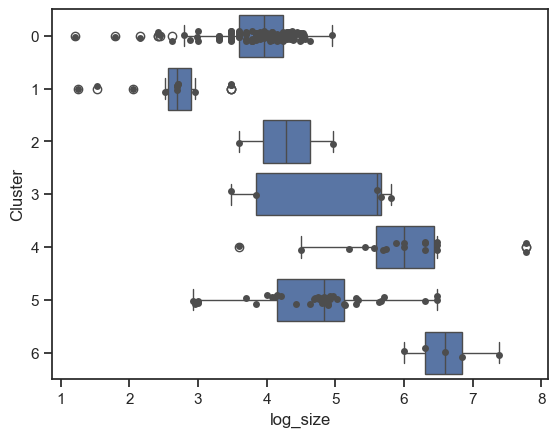

In [8]:
sns.boxplot(df_processed,x='log_size',y='Cluster')
sns.stripplot(df_processed,x='log_size',y='Cluster',color='.3')

In [18]:
df_processed.loc[df_processed.groupby('Cluster').num_vertices.idxmin()]

/var/folders/3h/362fjldd52n94x0vhdjj_6z80000gn/T/ipykernel_54855/2896216793.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_processed.loc[df_processed.groupby('Cluster').num_vertices.idxmin()]


,Graph Name,num_vertices,num_edges,assortativity_coeff,clustering_local_avg,density,log_density,log_size,log_density_norm,assortativity_norm,clustering_norm,Cluster,PCA1,PCA2
176,soc-tribes,16.0,58.0,0.05,0.54,0.483333,-0.315753,1.204120,1.753756,0.305472,1.712547,0,2.467532,-0.113796
207,ia-southernwomen,18.0,75.0,-0.21,0.74,0.490196,-0.309630,1.255273,1.758255,-1.069028,2.871187,1,3.032535,-1.732397
138,soc-pages-tvshow,4000.0,17000.0,0.56,0.37,0.002126,-2.672532,3.602060,0.022202,3.001606,0.727703,2,1.022912,2.727844
111,f socfb-nips-ego,3000.0,3000.0,-0.67,0.03,0.000667,-3.175946,3.477121,-0.347663,-3.500835,-1.241986,3,-1.690485,-3.086784
123,econ-poli,4000.0,4000.0,-0.29,0.05,0.000500,-3.300921,3.602060,-0.439483,-1.491951,-1.126122,4,-1.335921,-1.170053
193,la-crime-moreno,829.0,1000.0,-0.16,0.01,0.002914,-2.535555,2.918555,0.122841,-0.804701,-1.357850,5,-0.980413,-0.442189
192,inf-roadNet-PA,1000000.0,2000000.0,0.12,0.05,0.000004,-5.397940,6.000000,-1.980188,0.675530,-1.126122,6,-2.059598,0.917033


In [25]:
U@U.T

array([[1.00000000e+00, 1.91219641e-16],
       [1.91219641e-16, 1.00000000e+00]])